In [1]:
from os.path import join, split, isdir, dirname
from os import mkdir
from glob import glob
from cell_mrcnn.utils import get_image_description, calc_layers, convert_to_bit8, get_cell_mrcnn_path_from_config_file, get_image_paths, load_image
from skimage.io import imread
import tensorflow as tf
from cell_mrcnn import cell
import pandas as pd
import numpy as np
import cell_mrcnn.model as modellib
from PIL import Image
from datetime import datetime
from matplotlib import pyplot as plt
from itertools import product

Using TensorFlow backend.


In [2]:
data_path = join(get_cell_mrcnn_path_from_config_file(), 'data')
MODEL_DIR = join(get_cell_mrcnn_path_from_config_file(), "logs")
config = cell.CellInferenceConfig()

In [3]:
mask_dir = join(data_path, '20201210/preprocessed/venus')
dataset_dir = join(data_path, '20201210')

In [4]:
genotypes = ['L','Q','wt']
stim = ['st', 'nst']
wells = ['_'.join(prod) for prod in product(genotypes, stim)]
# get the CB2 channel paths for each well
cb2_paths = get_image_paths(dataset_dir, channels=('Venus'), genotypes=('wt', 'Q', 'L'), stims=('st', 'nst'))
cb2_path_dict = {}
# get the image paths for mask prediction (could be the same, could be different)
mask_image_paths = glob(join(mask_dir, '*.png'))
mask_path_dict = {}
# initialise other dicts
result_dict = {}
df_dict = {}
for well in wells:
    cb2_path_dict[well] = {}
    mask_path_dict[well] = {}
    result_dict[well] = {}
    df_dict[well] = pd.DataFrame()
    
for path in cb2_paths:
    ch, gen, st, pos = get_image_description(path)
    well = '_'.join((gen,st))
    cb2_path_dict[well][pos] = path

for path in mask_image_paths:
    ch, gen, st, pos = get_image_description(path)
    well = '_'.join((gen,st))
    mask_path_dict[well][pos] = path

In [5]:
config.DETECTION_MIN_CONFIDENCE = 0.9
DEVICE = "/cpu:0"
with tf.device(DEVICE):
    model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR,
                                      config=config)
    weights_path = join(MODEL_DIR, "cell20201216T2001/mask_rcnn_cell_0020.h5")
    print("Loading weights ", weights_path)
    model.load_weights(weights_path, by_name=True)








Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
box_ind is deprecated, use box_indices instead


Instructions for updating:
Use `tf.cast` instead.
Loading weights  /media/miska/Data/cell_mrcnn_data/logs/cell20201216T2001/mask_rcnn_cell_0020.h5






Re-starting from epoch 20


In [6]:
for i, well in enumerate(wells):
    for j,(pos, path) in enumerate(cb2_path_dict[well].items()):
        print('\r{}/{} well: {}/{} position...'.format(i+1, len(wells), j+1, len(cb2_path_dict[well].items())), end='')
        layers_image = imread(path)
        mask_image = load_image(mask_path_dict[well][pos])
        results = model.detect([mask_image], verbose=0)[0]
        result_dict[well][pos] = results
        layers = calc_layers(layers_image, results['masks'])
        df = pd.DataFrame(layers)
        df_dict[well] = pd.concat([df_dict[well], df], axis=0, ignore_index = True)
    df_dict[well].loc['mean',:] = df_dict[well].mean(axis=0)

6/6 well: 25/25 position...

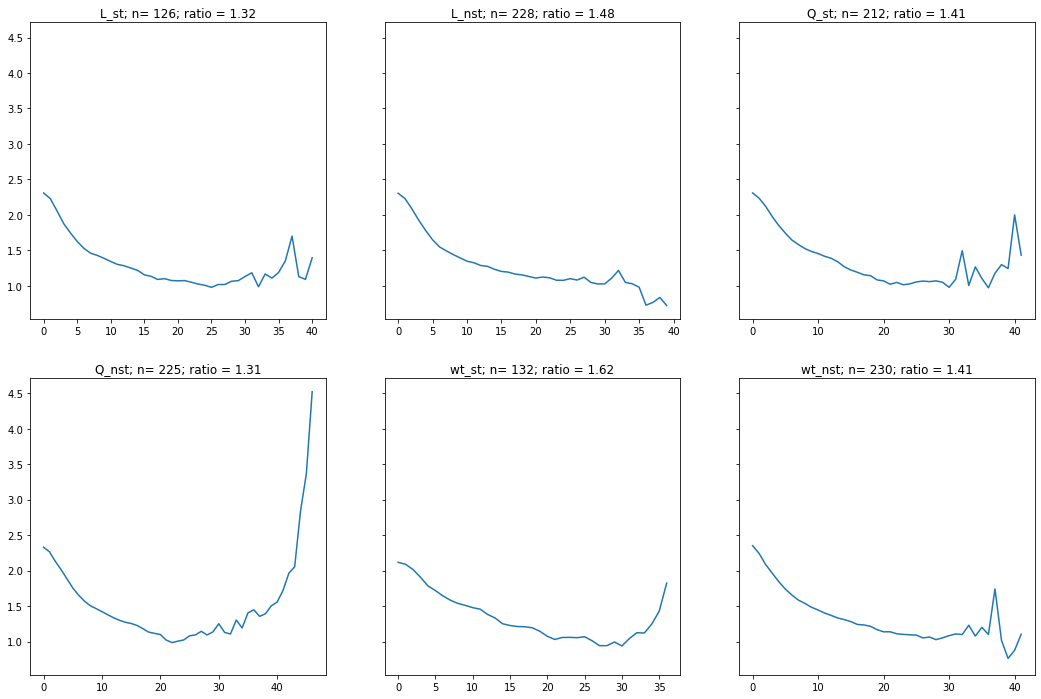

In [7]:
rows=2; cols=3; size = 6
fig, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows), sharey = True)
row, col = 0, 0
for j, well in enumerate(wells):
    ax[row, col].plot(np.arange(len(df_dict[well].loc['mean',:])), df_dict[well].loc['mean',:])
    ratio = df_dict[well].loc['mean',:][:20].sum() / df_dict[well].loc['mean',:][20:40].sum()
    ax[row, col].set_title(f"{well}; n= {df_dict[well].shape[0]-1}; ratio = {ratio:.2f}")
    col += 1
    if (j+1) % 3 == 0:
        row += 1
        col = 0

In [8]:
# save the results
results_dir = join(get_cell_mrcnn_path_from_config_file(),'results')
if not isdir(results_dir):
    mkdir(results_dir)
date = datetime.now().strftime("%Y_%m_%d_%H_%M_%S")
output_folder = join(results_dir, date)
if not isdir(output_folder):
    mkdir(output_folder)
for well in result_dict.keys():
    well_dir = join(output_folder, well)
    if not isdir(well_dir):
        mkdir(well_dir)
    with open(join(well_dir, 'results.csv'), 'w') as f:
        f.write(df_dict[well].to_csv())
    for pos, r in result_dict[well].items():
        for m in range(r['masks'].shape[2]):
            mask_ = Image.fromarray((r['masks'][:,:,m]*255).astype(np.uint8),
                                    mode = 'L')
            mask_ = mask_.convert(mode='1')
            mask_.save(join(well_dir, pos + '_mask_' + str(m) +
                       '.png'))